# RNN with LSTM for japanese character classification

100 1% (0m 18s) 1.6999 data/train\e__26726.csv / u ✗ (e)
200 2% (0m 35s) 1.5948 data/train\o__13234.csv / u ✗ (o)
300 3% (0m 53s) 1.5701 data/train\u__47583.csv / u ✓
400 4% (1m 10s) 1.6207 data/train\e__54428.csv / u ✗ (e)
500 5% (1m 27s) 1.6090 data/train\a__28749.csv / o ✗ (a)
600 6% (1m 44s) 1.5769 data/train\e__28466.csv / e ✓
700 7% (2m 1s) 1.5821 data/train\u__13045.csv / o ✗ (u)
800 8% (2m 18s) 1.5690 data/train\u__15626.csv / o ✗ (u)
900 9% (2m 35s) 1.6377 data/train\a__40557.csv / u ✗ (a)
1000 10% (2m 52s) 1.6406 data/train\i__97008.csv / u ✗ (i)
1100 11% (3m 9s) 1.6202 data/train\i__97008.csv / u ✗ (i)
1200 12% (3m 25s) 1.6154 data/train\a__28749.csv / i ✗ (a)
1300 13% (3m 41s) 1.6447 data/train\o__92303.csv / i ✗ (o)
1400 14% (3m 58s) 1.5276 data/train\i__02797.csv / i ✓
1500 15% (4m 18s) 1.4778 data/train\o__03230.csv / o ✓
1600 16% (4m 41s) 1.4969 data/train\e__32221.csv / a ✗ (e)
1700 17% (5m 0s) 1.6651 data/train\e__66362.csv / a ✗ (e)
1800 18% (5m 18s) 1.6558 data/trai

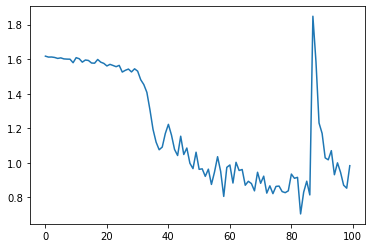

In [8]:
import time
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

from utils import load_data, file_to_tensor, character_to_tensor, random_training_example

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset
character_files, all_characters = load_data(subfolder="train")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
num_characters = len(all_characters) # output_size
hidden_size = 128
num_layers = 1

learning_rate = 0.008


class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_characters):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, num_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        
        # output of shape (seq_len, batch, num_directions * hidden_size)
        out, _ = self.lstm(x, (h0,c0))
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)
        
        return out

    
model = RNN(input_size, hidden_size, num_layers, num_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


def train(file_tensor, character_tensor):
    output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()


def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

current_loss = 0
all_losses = []

print_every = 100
plot_every = 100
n_iterations = 10000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iterations + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor, character_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iterations * 100, timeSince(start), loss, file, guess, correct))

    # Add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
plt.show()